In [201]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [202]:
# loading the data from csv file
df = pd.read_csv('train/train.csv')

In [203]:
df.columns

Index(['date', 'store', 'item', 'sales'], dtype='object')

In [204]:
# selecting data for item and store wise prediction: item 15 from store 8
df = df[(df['item']==15)&(df['store']==8)]
df.drop(['item', 'store'], axis=1, inplace=True)

In [205]:
df.shape


(1826, 2)

In [206]:
# converting the date into dayofyear, dayofweek, month and year
def convert_dates(x):
    x['date']=pd.to_datetime(x['date'])
    x['month']=x['date'].dt.month
    x['year']=x['date'].dt.year
    x['dayofweek']=x['date'].dt.dayofweek
    x['dayofyear'] = x['date'].dt.dayofyear
    x.pop('date')
    return x

In [207]:
df = convert_dates(df)

In [208]:
df.tail(5)

,sales,month,year,dayofweek,dayofyear
270243,81,12,2017,2,361
270244,86,12,2017,3,362
270245,86,12,2017,4,363
270246,119,12,2017,5,364
270247,105,12,2017,6,365


In [209]:
# Adding 7 columns for previous 7 days data
cols7 = []
for i in range(1,8):
    col = pd.DataFrame(df.shift(i)['sales'])
    col.rename(columns={'sales': 'sales_d-{}'.format(i)},inplace=True)
    cols7.append(col)
df = pd.concat([df]+cols7, axis=1)
    

In [210]:
# Adding an attribute for sales same day last year 
col = pd.DataFrame(df.shift(365)['sales'])
col.rename(columns={'sales': 'sales_samedaylastyear'.format(i)},inplace=True)
df = pd.concat([df, col], axis=1)

In [211]:
# since there are many NaNs due to time shifting, which needs to be removed
df.dropna(axis=0, inplace=True)

In [212]:
df.head()

,sales,month,year,dayofweek,dayofyear,sales_d-1,sales_d-2,sales_d-3,sales_d-4,sales_d-5,sales_d-6,sales_d-7,sales_samedaylastyear
268787,68,1,2014,2,1,67.0,52.0,89.0,80.0,59.0,63.0,69.0,44.0
268788,75,1,2014,3,2,68.0,67.0,52.0,89.0,80.0,59.0,63.0,56.0
268789,68,1,2014,4,3,75.0,68.0,67.0,52.0,89.0,80.0,59.0,59.0
268790,89,1,2014,5,4,68.0,75.0,68.0,67.0,52.0,89.0,80.0,66.0
268791,103,1,2014,6,5,89.0,68.0,75.0,68.0,67.0,52.0,89.0,83.0


In [213]:
# year 2014, 2015, 2016 for training; year 2017 for testing and evaluation of model
x_train = df[df['year']<=2016]
y_train = x_train.pop('sales')
x_test = df[df['year']==2017]
y_test = x_test.pop('sales')

In [214]:
x_test

,month,year,dayofweek,dayofyear,sales_d-1,sales_d-2,sales_d-3,sales_d-4,sales_d-5,sales_d-6,sales_d-7,sales_samedaylastyear
269883,1,2017,6,1,96.0,90.0,104.0,74.0,99.0,59.0,117.0,96.0
269884,1,2017,0,2,120.0,96.0,90.0,104.0,74.0,99.0,59.0,87.0
269885,1,2017,1,3,75.0,120.0,96.0,90.0,104.0,74.0,99.0,68.0
269886,1,2017,2,4,86.0,75.0,120.0,96.0,90.0,104.0,74.0,61.0
269887,1,2017,3,5,85.0,86.0,75.0,120.0,96.0,90.0,104.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...
270243,12,2017,2,361,91.0,67.0,102.0,91.0,91.0,103.0,76.0,99.0
270244,12,2017,3,362,81.0,91.0,67.0,102.0,91.0,91.0,103.0,74.0
270245,12,2017,4,363,86.0,81.0,91.0,67.0,102.0,91.0,91.0,104.0
270246,12,2017,5,364,86.0,86.0,81.0,91.0,67.0,102.0,91.0,90.0


In [215]:
def XGBmodel(x_train,x_test,y_train,y_test):
    matrix_train = xgb.DMatrix(x_train,label=y_train)
    matrix_test = xgb.DMatrix(x_test,label=y_test)
    model=xgb.train(params={'objective':'reg:linear','eval_metric':'mae'}
                    ,dtrain=matrix_train,num_boost_round=500, 
                    early_stopping_rounds=20,evals=[(matrix_test,'test')],)
    return model

model=XGBmodel(x_train,x_test,y_train,y_test)

[22:18:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-mae:86.14963
[1]	test-mae:61.10377
[2]	test-mae:44.05579
[3]	test-mae:31.98357
[4]	test-mae:23.75933
[5]	test-mae:18.35257
[6]	test-mae:15.08039
[7]	test-mae:13.21814
[8]	test-mae:12.16526
[9]	test-mae:11.61303
[10]	test-mae:11.26231
[11]	test-mae:11.01623
[12]	test-mae:10.79115
[13]	test-mae:10.71253
[14]	test-mae:10.64863
[15]	test-mae:10.70610
[16]	test-mae:10.66628
[17]	test-mae:10.74140
[18]	test-mae:10.78966
[19]	test-mae:10.78111
[20]	test-mae:10.76367
[21]	test-mae:10.76995
[22]	test-mae:10.80536
[23]	test-mae:10.77413
[24]	test-mae:10.82423
[25]	test-mae:10.87837
[26]	test-mae:10.83112
[27]	test-mae:10.87911
[28]	test-mae:10.92283
[29]	test-mae:10.94907
[30]	test-mae:10.97072
[31]	test-mae:11.00335
[32]	test-mae:11.03635
[33]	test-mae:11.05349
[34]	test-mae:11.04583


In [216]:

y_pred = model.predict(xgb.DMatrix(x_test), ntree_limit = model.best_ntree_limit)


C:\Users\deepa\anaconda3\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [217]:
df_17 = x_test.copy()
df_17.loc[:,'pred_sales'] = y_pred
df_17.loc[:,'actual_sales'] = y_test

In [218]:
df_17

,month,year,dayofweek,dayofyear,sales_d-1,sales_d-2,sales_d-3,sales_d-4,sales_d-5,sales_d-6,sales_d-7,sales_samedaylastyear,pred_sales,actual_sales
269883,1,2017,6,1,96.0,90.0,104.0,74.0,99.0,59.0,117.0,96.0,110.231590,120
269884,1,2017,0,2,120.0,96.0,90.0,104.0,74.0,99.0,59.0,87.0,64.820442,75
269885,1,2017,1,3,75.0,120.0,96.0,90.0,104.0,74.0,99.0,68.0,86.193047,86
269886,1,2017,2,4,86.0,75.0,120.0,96.0,90.0,104.0,74.0,61.0,77.392128,85
269887,1,2017,3,5,85.0,86.0,75.0,120.0,96.0,90.0,104.0,62.0,85.878792,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270243,12,2017,2,361,91.0,67.0,102.0,91.0,91.0,103.0,76.0,99.0,84.027382,81
270244,12,2017,3,362,81.0,91.0,67.0,102.0,91.0,91.0,103.0,74.0,92.183342,86
270245,12,2017,4,363,86.0,81.0,91.0,67.0,102.0,91.0,91.0,104.0,88.787987,86
270246,12,2017,5,364,86.0,86.0,81.0,91.0,67.0,102.0,91.0,90.0,89.949997,119


In [219]:
import matplotlib.pyplot as plt
# plotting function for any type of sales plot
def plot_sales(x1, x2=None):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5), dpi =300)
    
    axes.plot(range(1,len(x1)+1), x1,label='Actual sales', lw=1)
    if x2 is not None:
        axes.plot(range(1,len(x1)+1), x2,label='Predicted sales', lw=1)
        axes.set_title('Comparision between estimated and predicted sales')
    else:
        axes.set_title('Plot showing actual sales')
        
    axes.set_xlabel('Day')
    axes.set_ylabel('Sales')
    axes.legend()
    axes.grid(True)
    fig.tight_layout()
    plt.show()

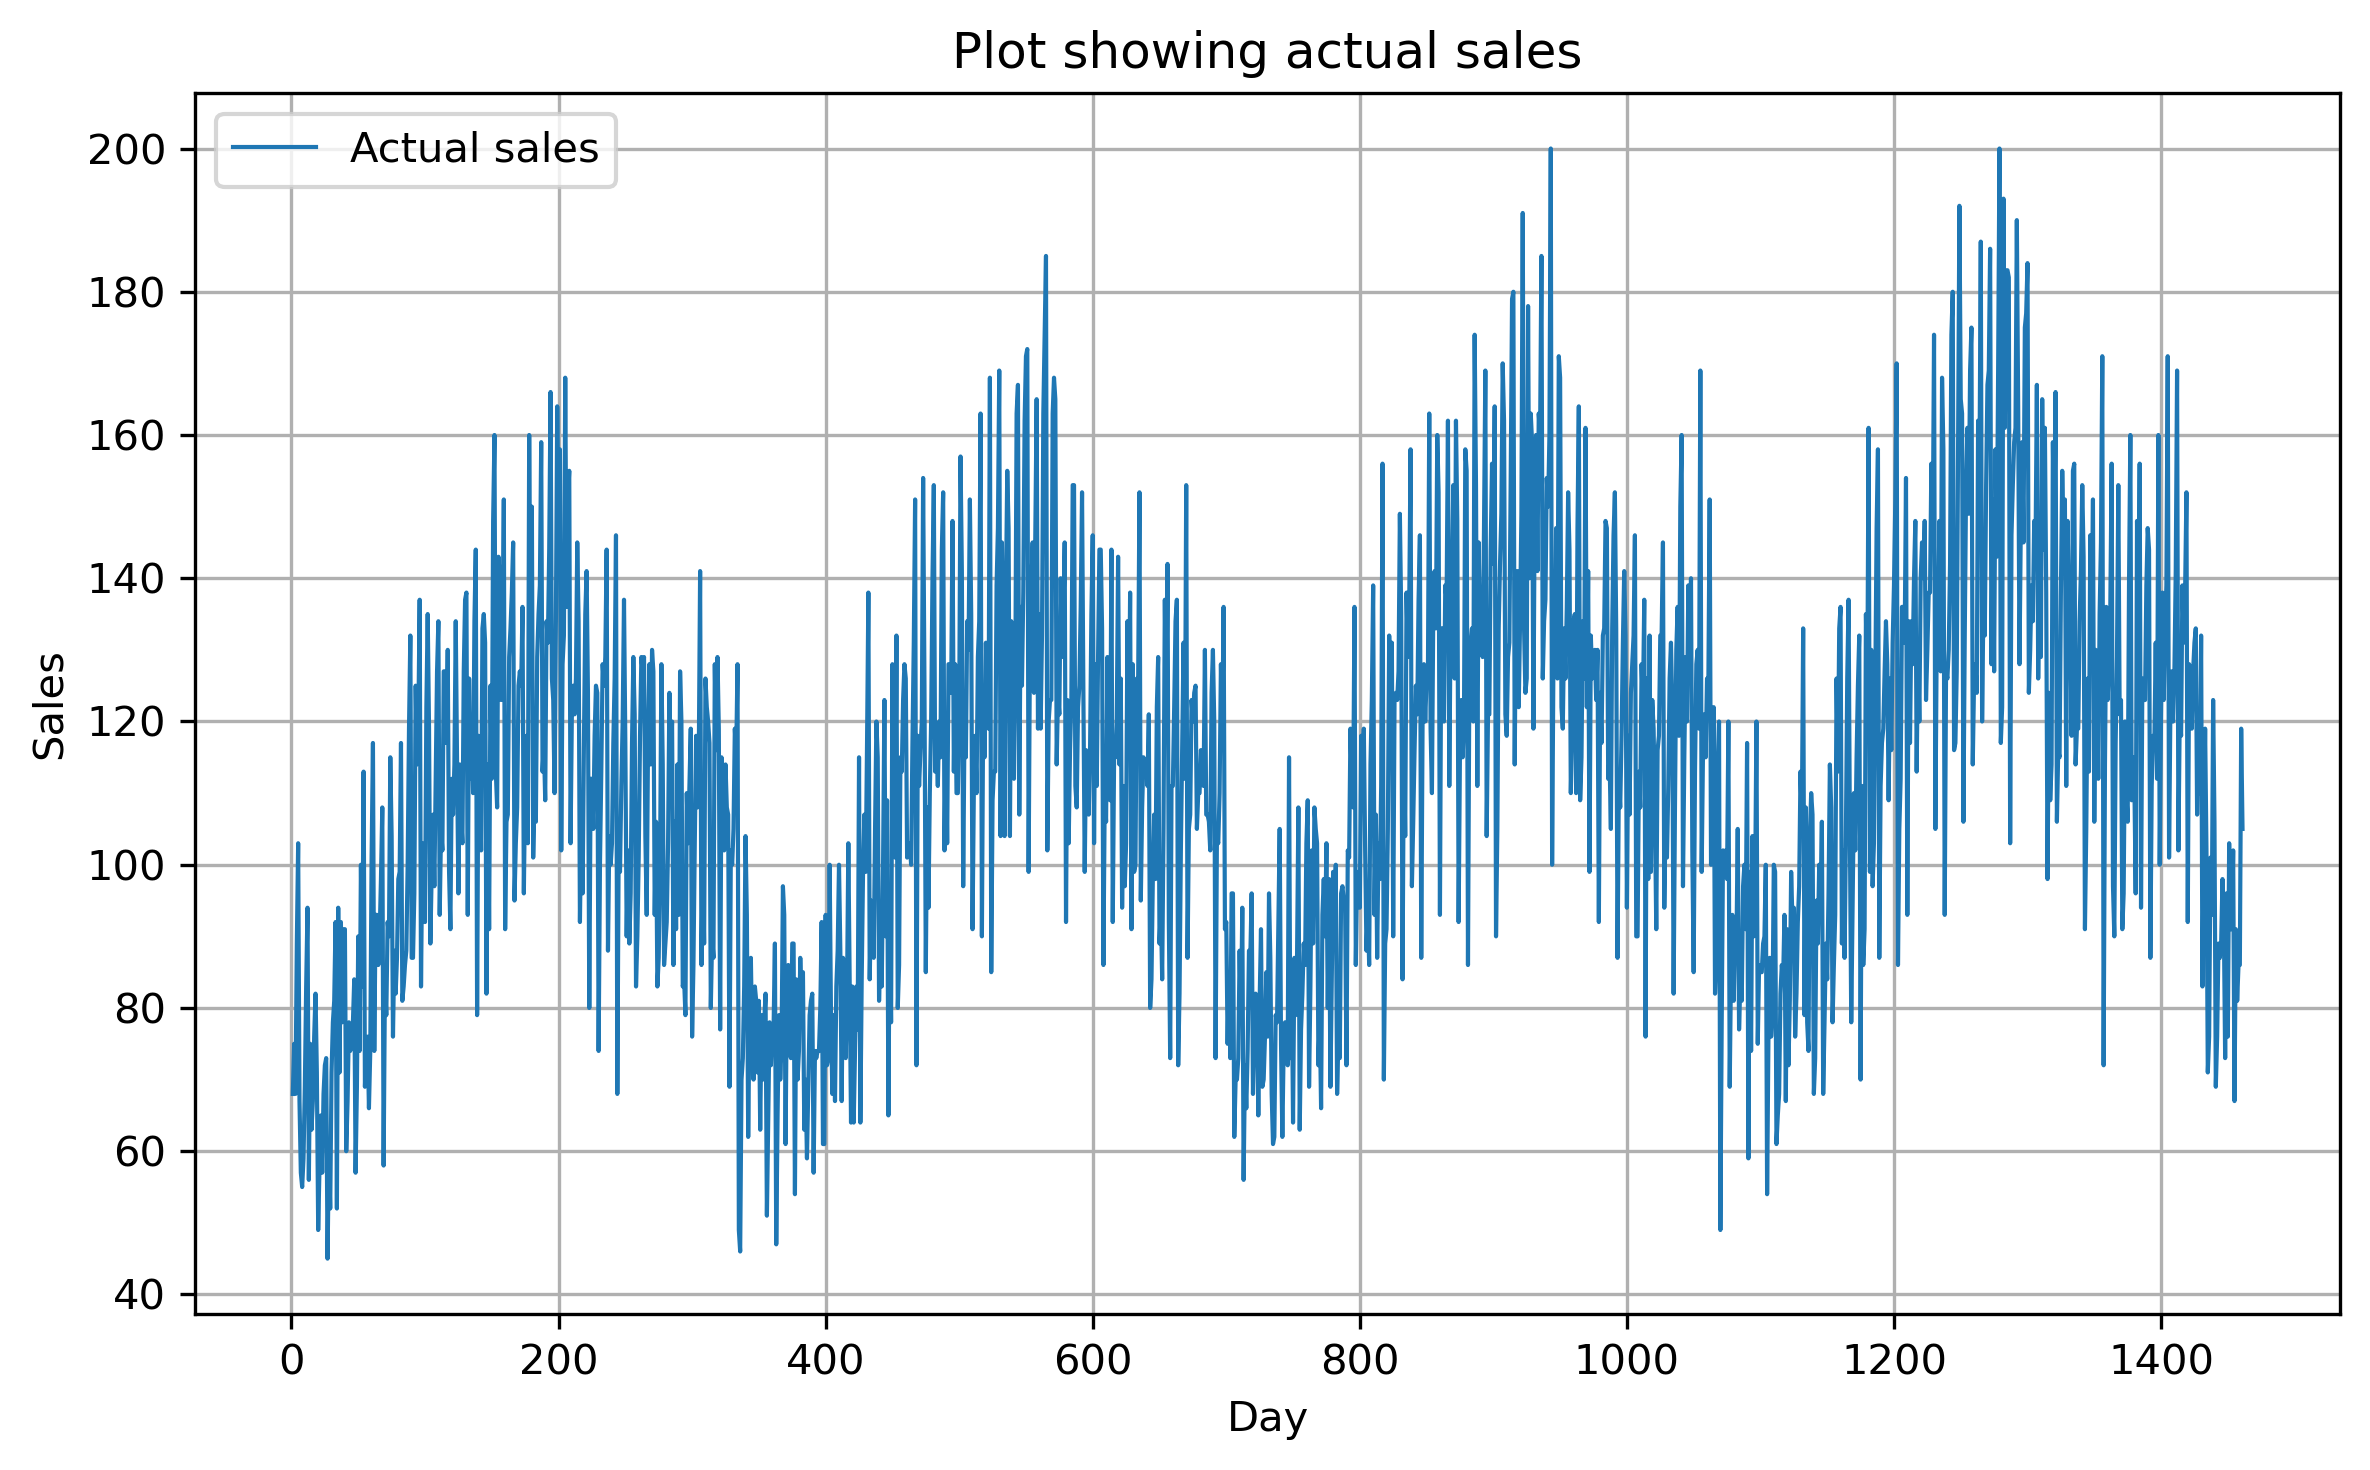

In [227]:
# Whole dataset plot
plot_sales(x1=df['sales'])

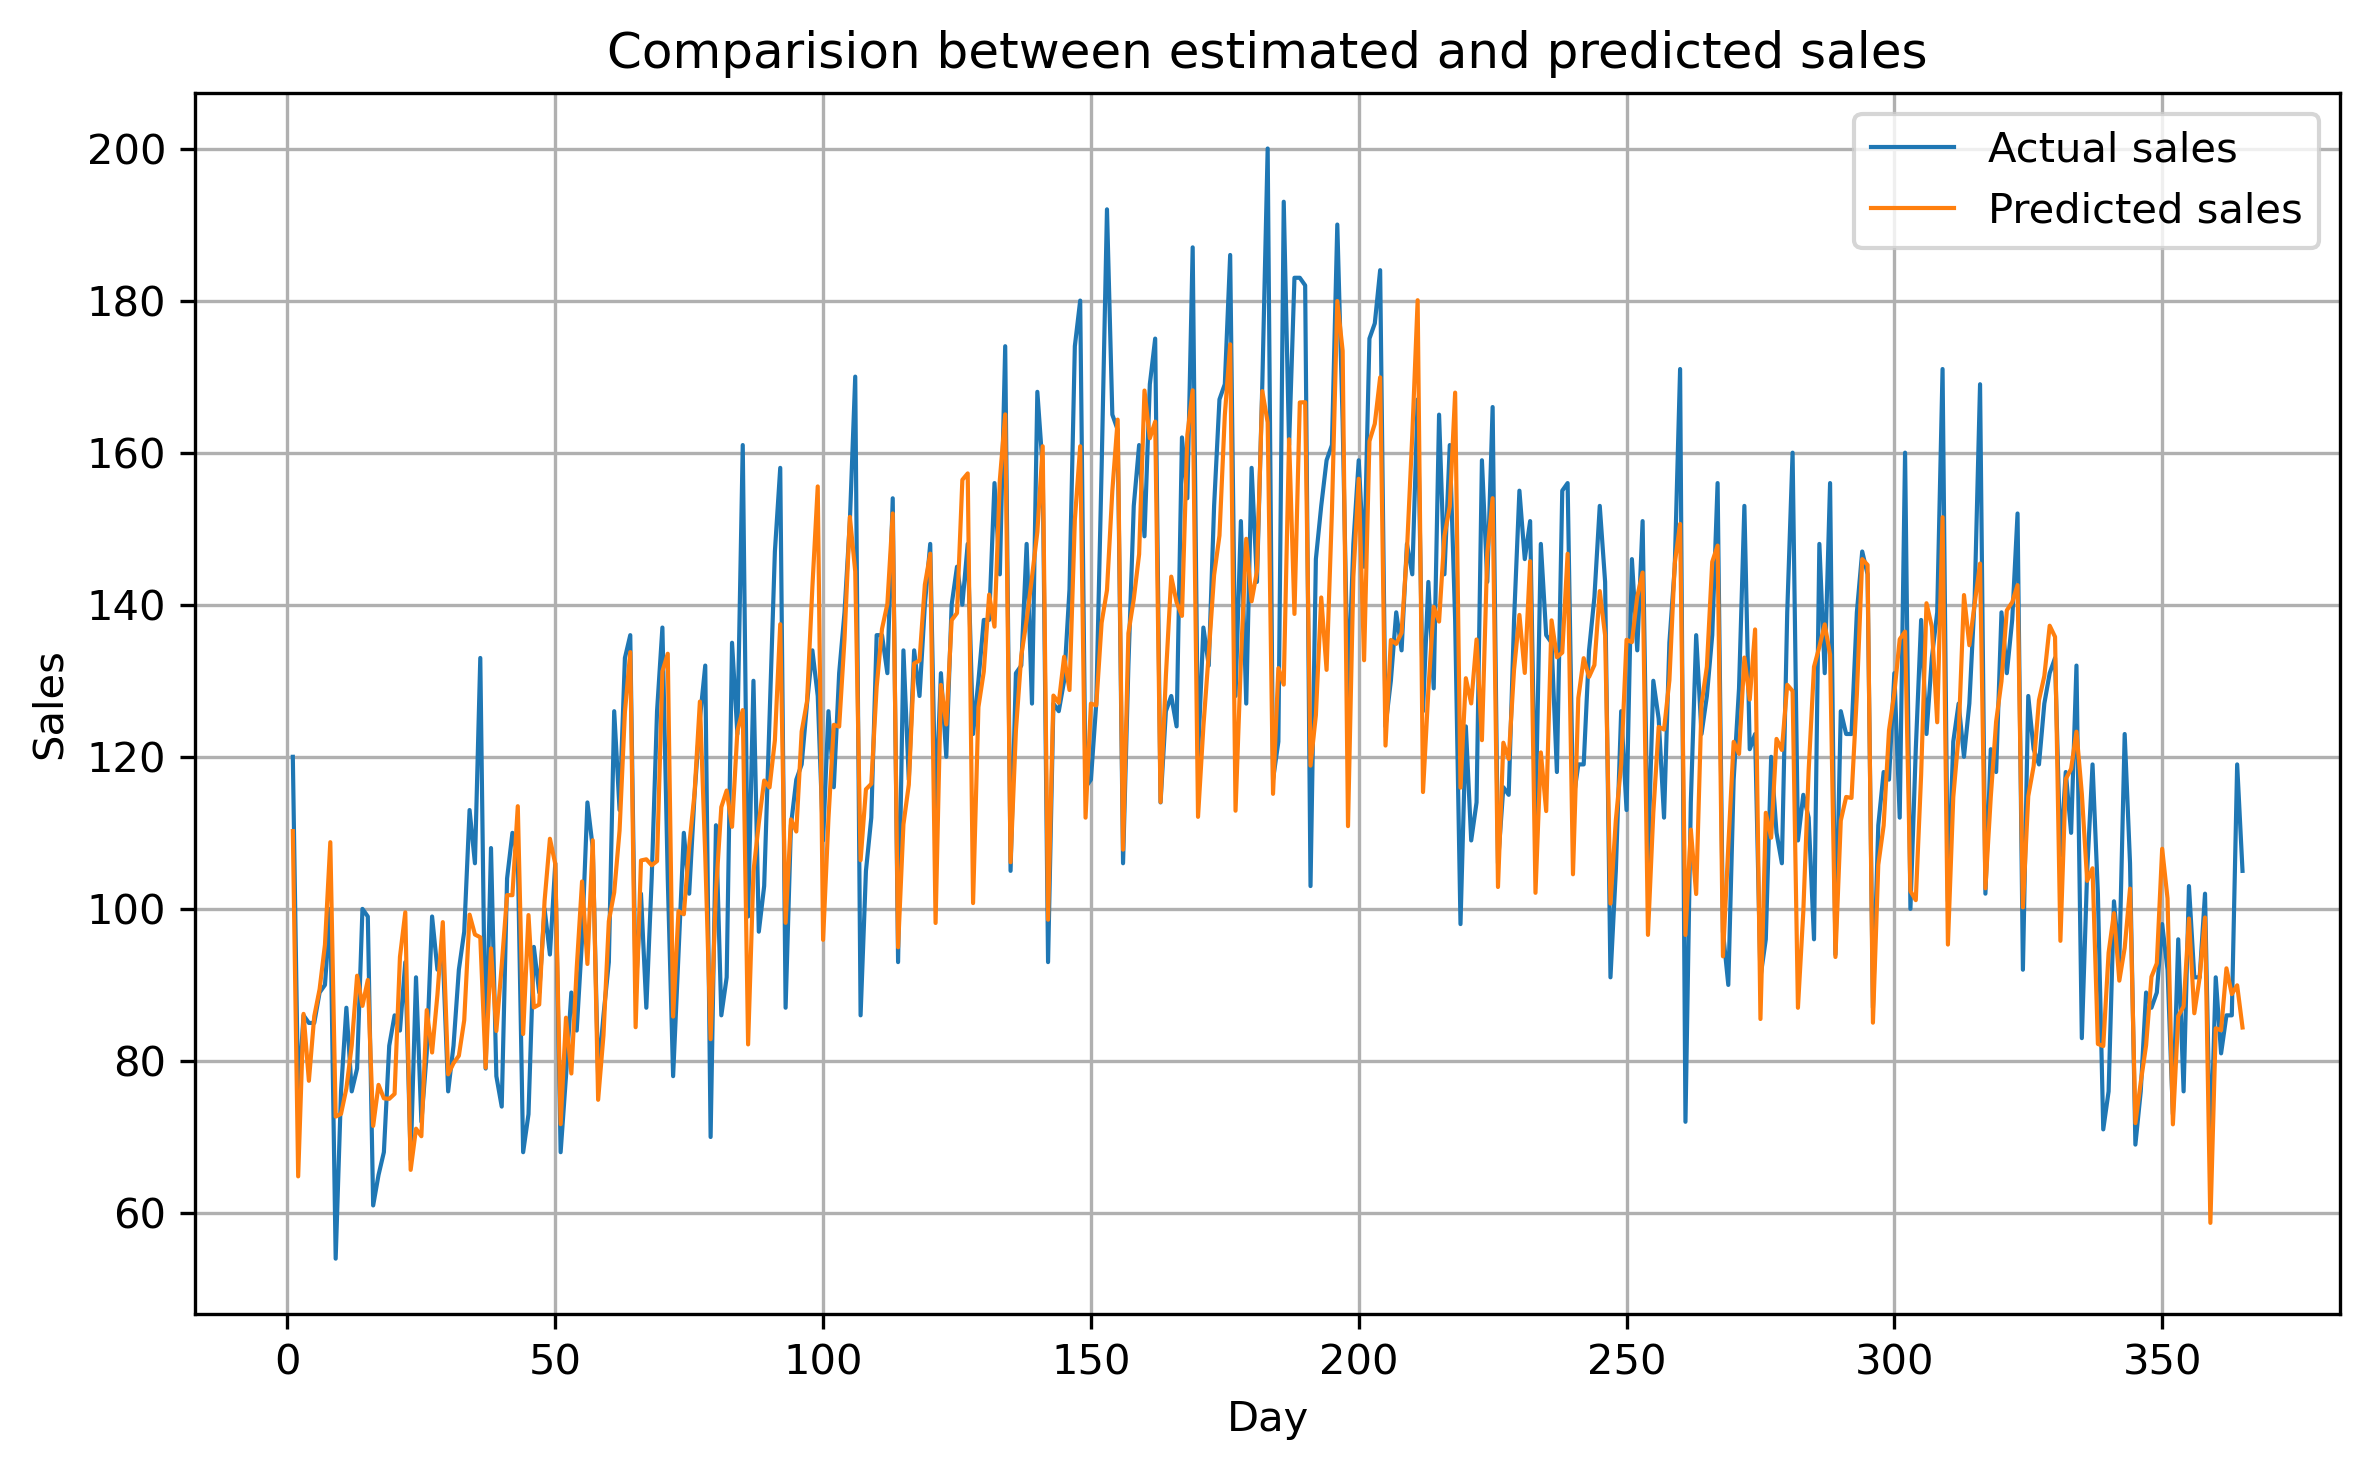

In [228]:
# whole 2017 year plot
plot_sales(x1=df_17['actual_sales'], x2=df_17['pred_sales'])


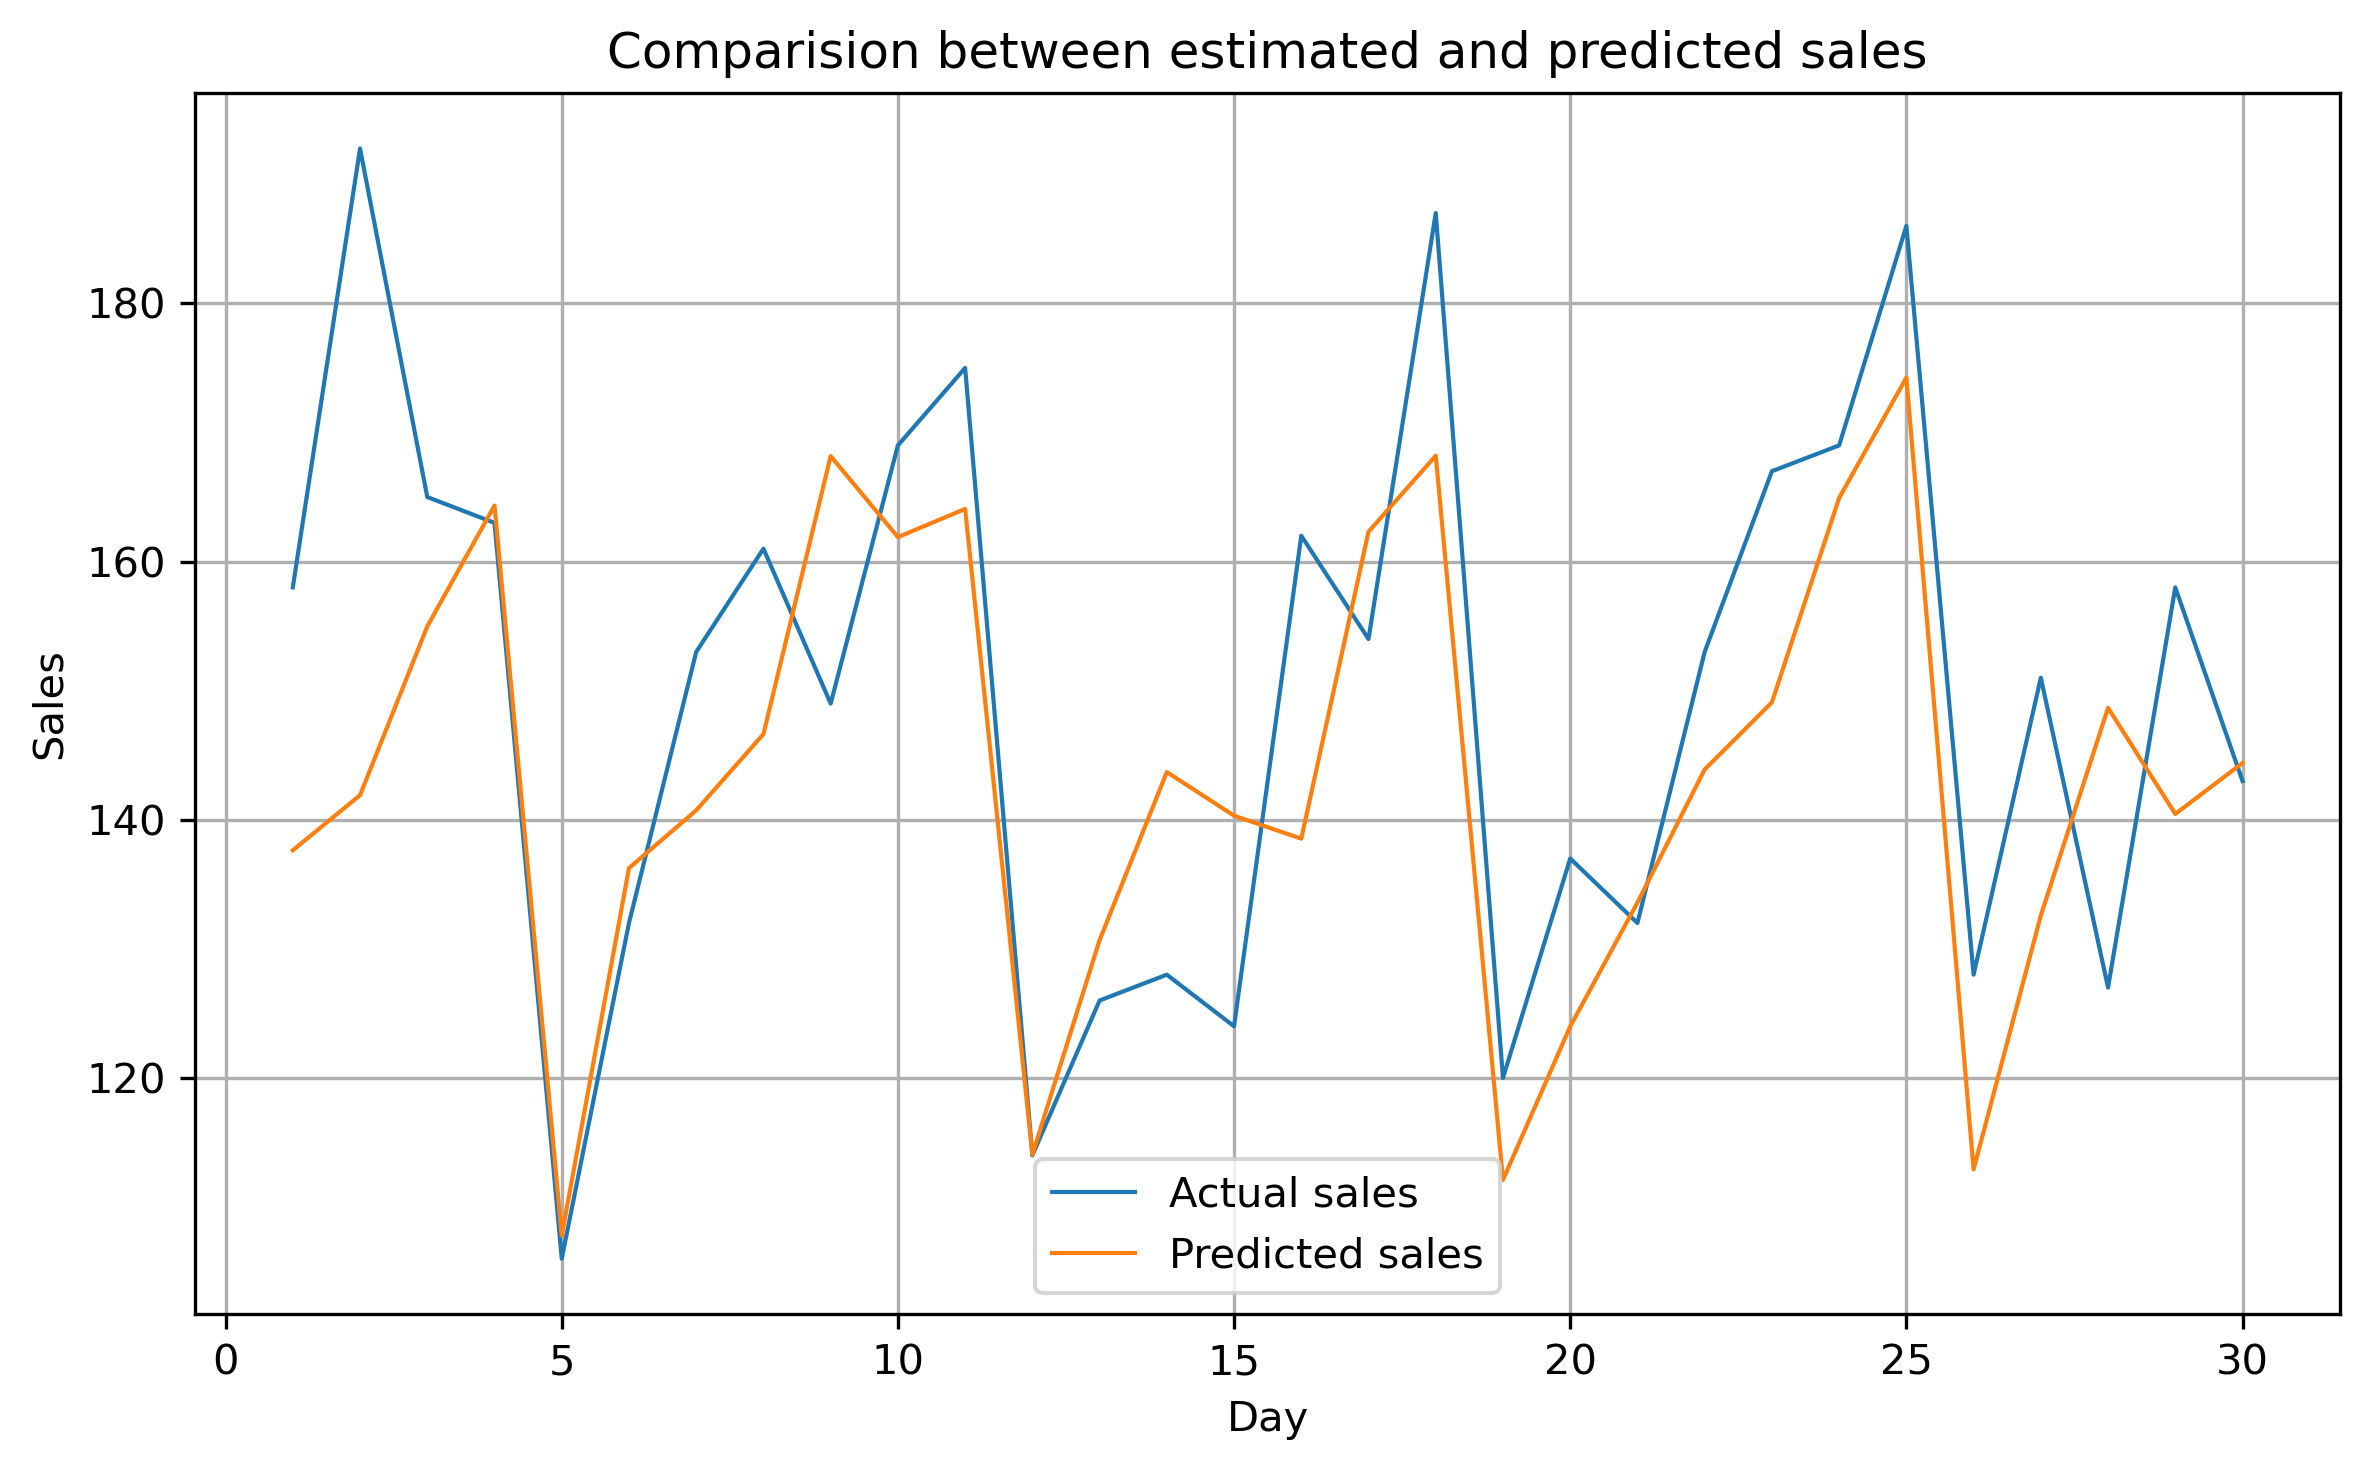

In [221]:
# June 2017 plot
plot_sales(x1=df_17[df_17['month']==6]['actual_sales'], x2=df_17[df_17['month']==6]['pred_sales'])

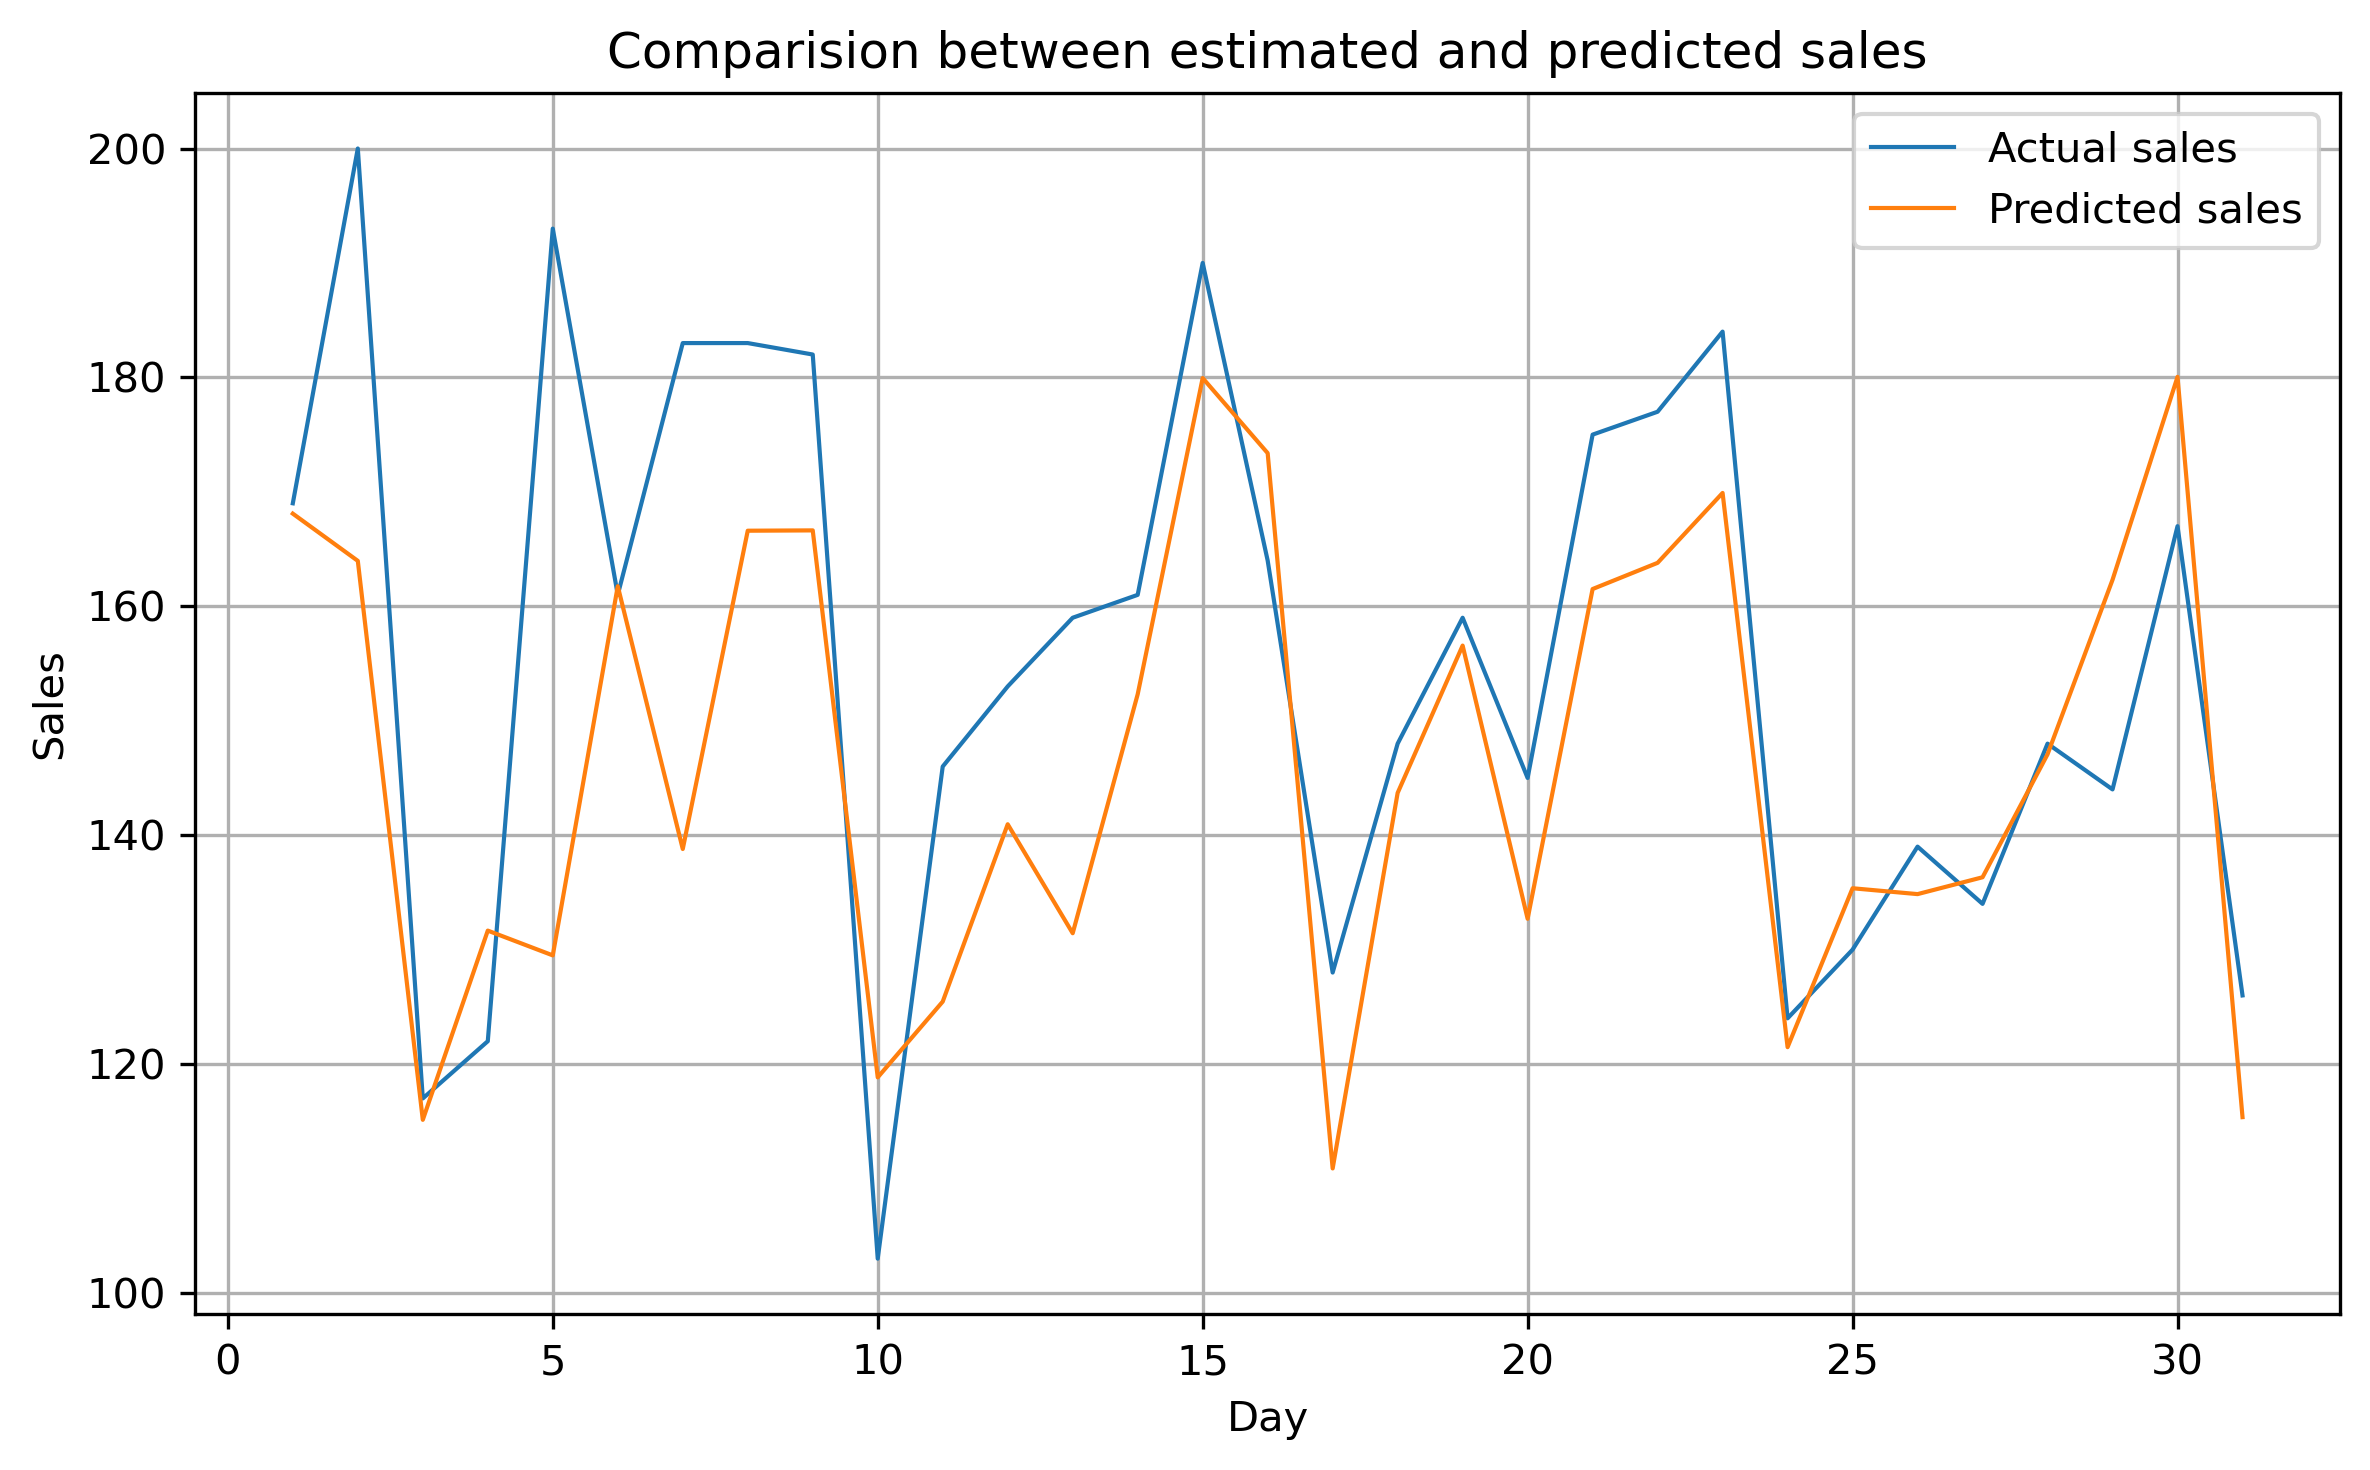

In [222]:
# July 2017 plot
plot_sales(x1=df_17[df_17['month']==7]['actual_sales'], x2=df_17[df_17['month']==7]['pred_sales'])

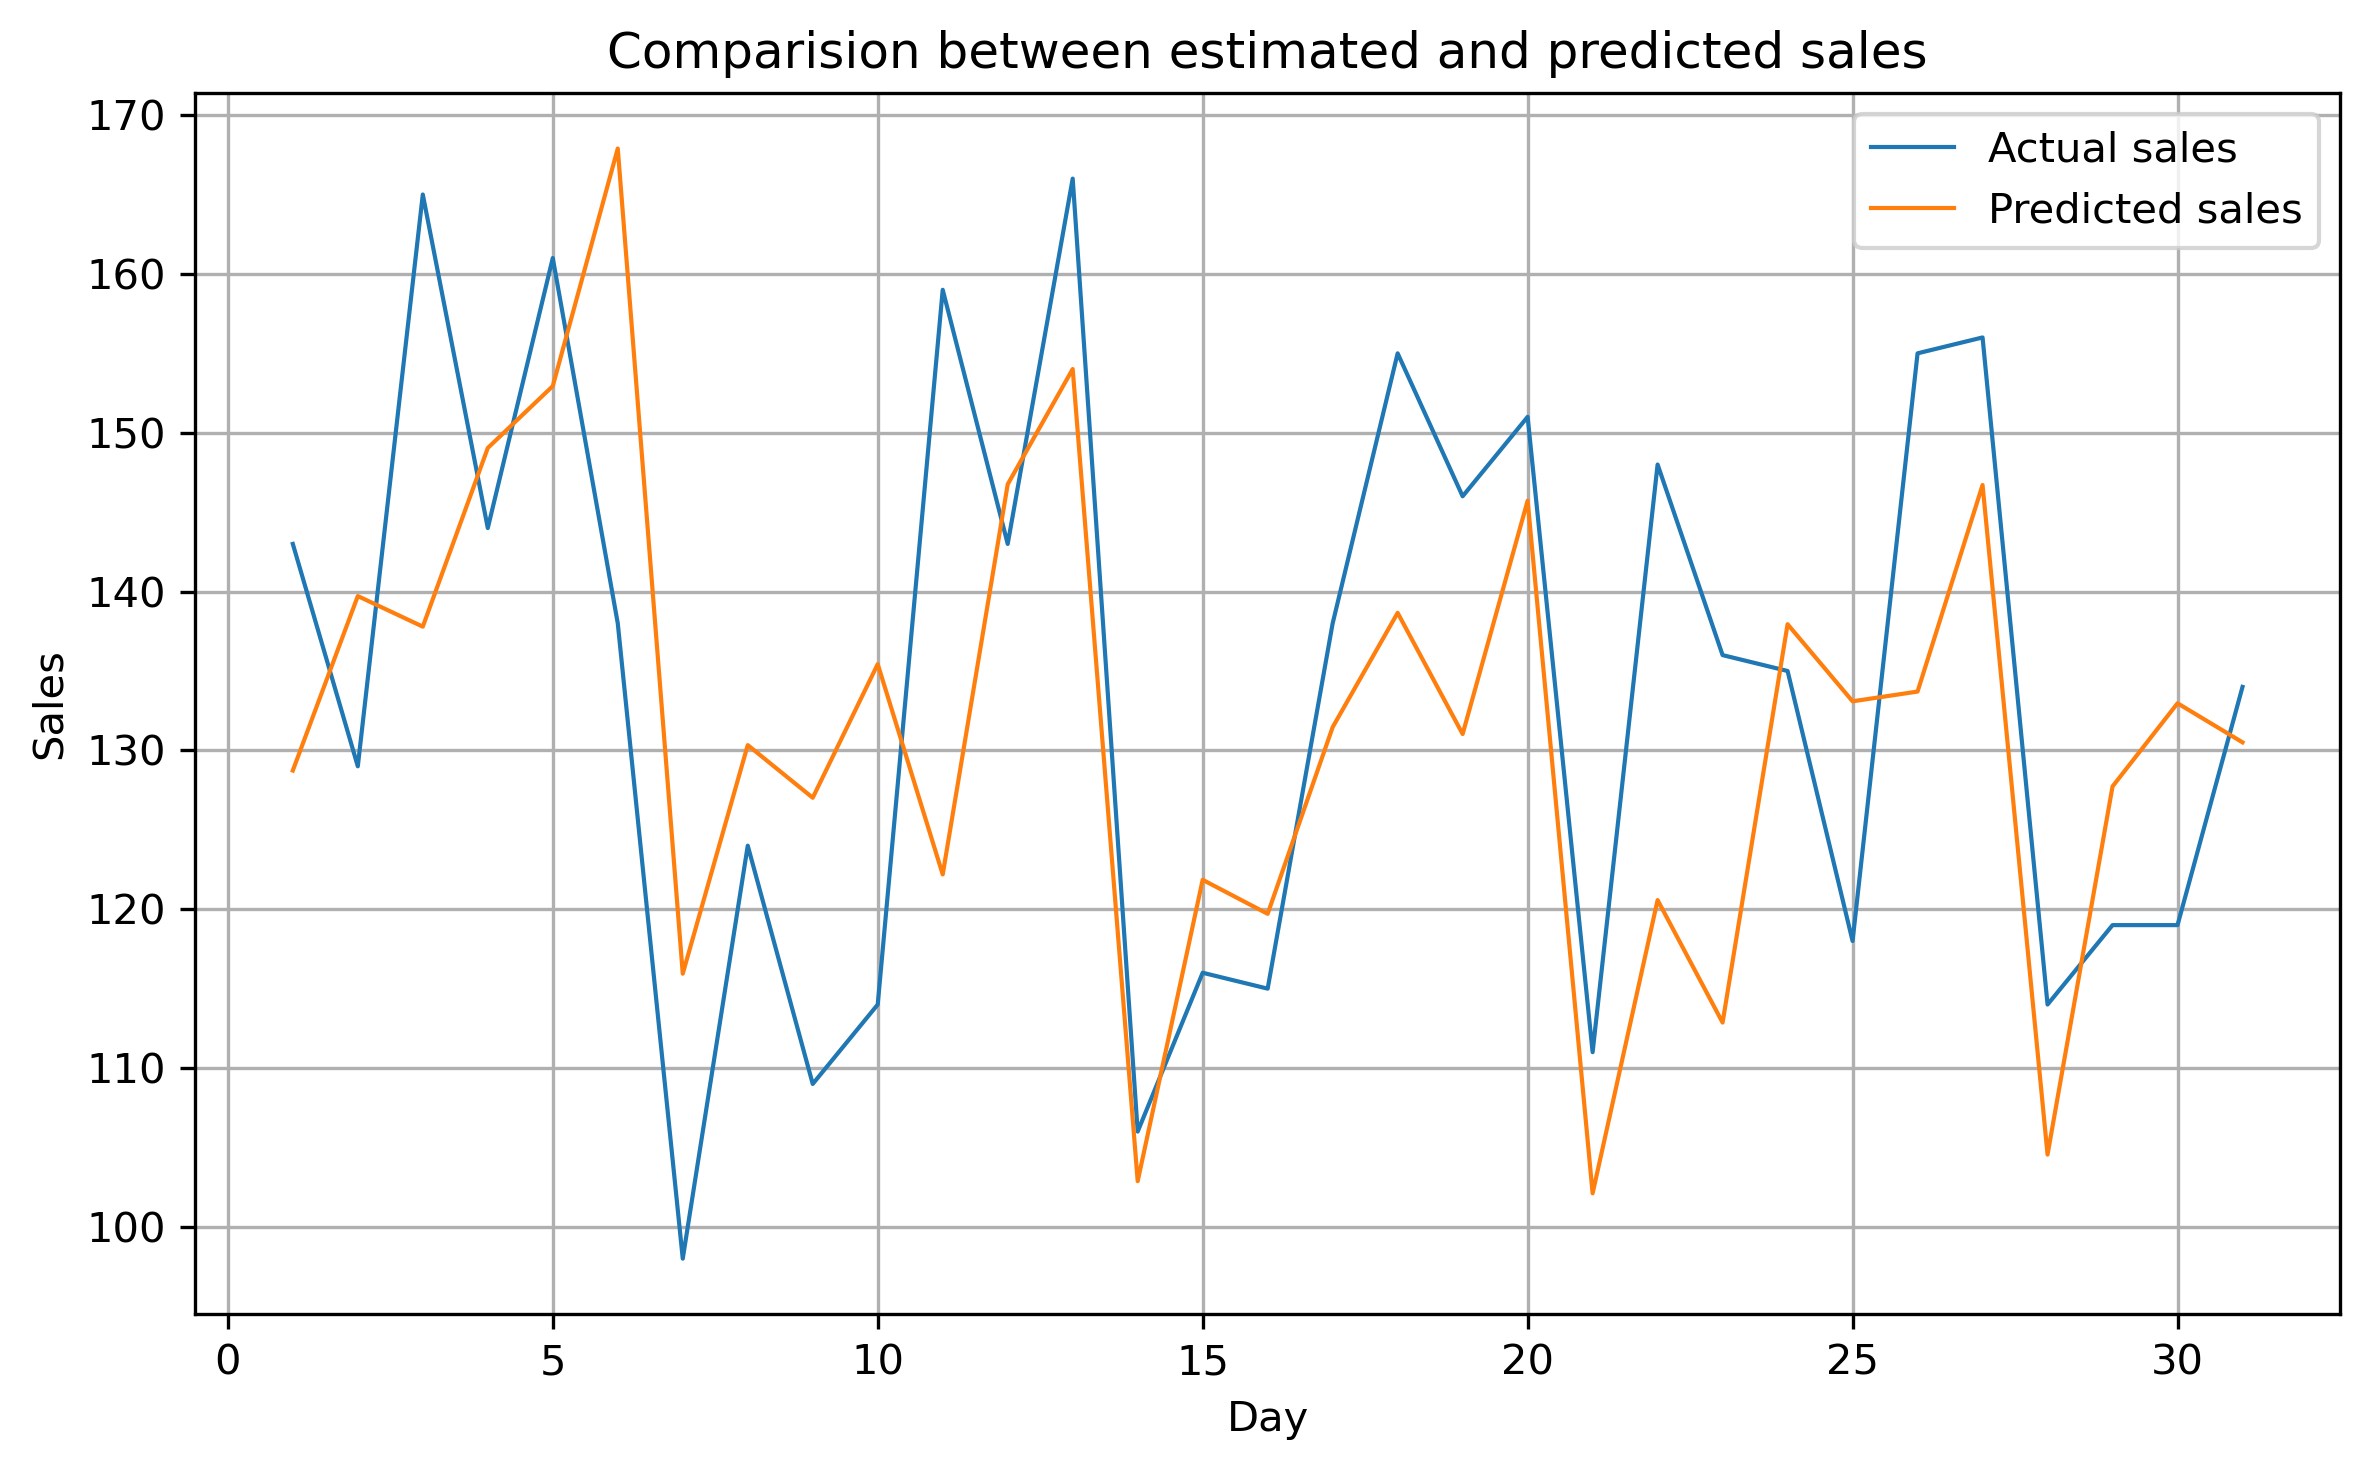

In [223]:
# August 2017 plot
plot_sales(x1=df_17[df_17['month']==8]['actual_sales'], x2=df_17[df_17['month']==8]['pred_sales'])

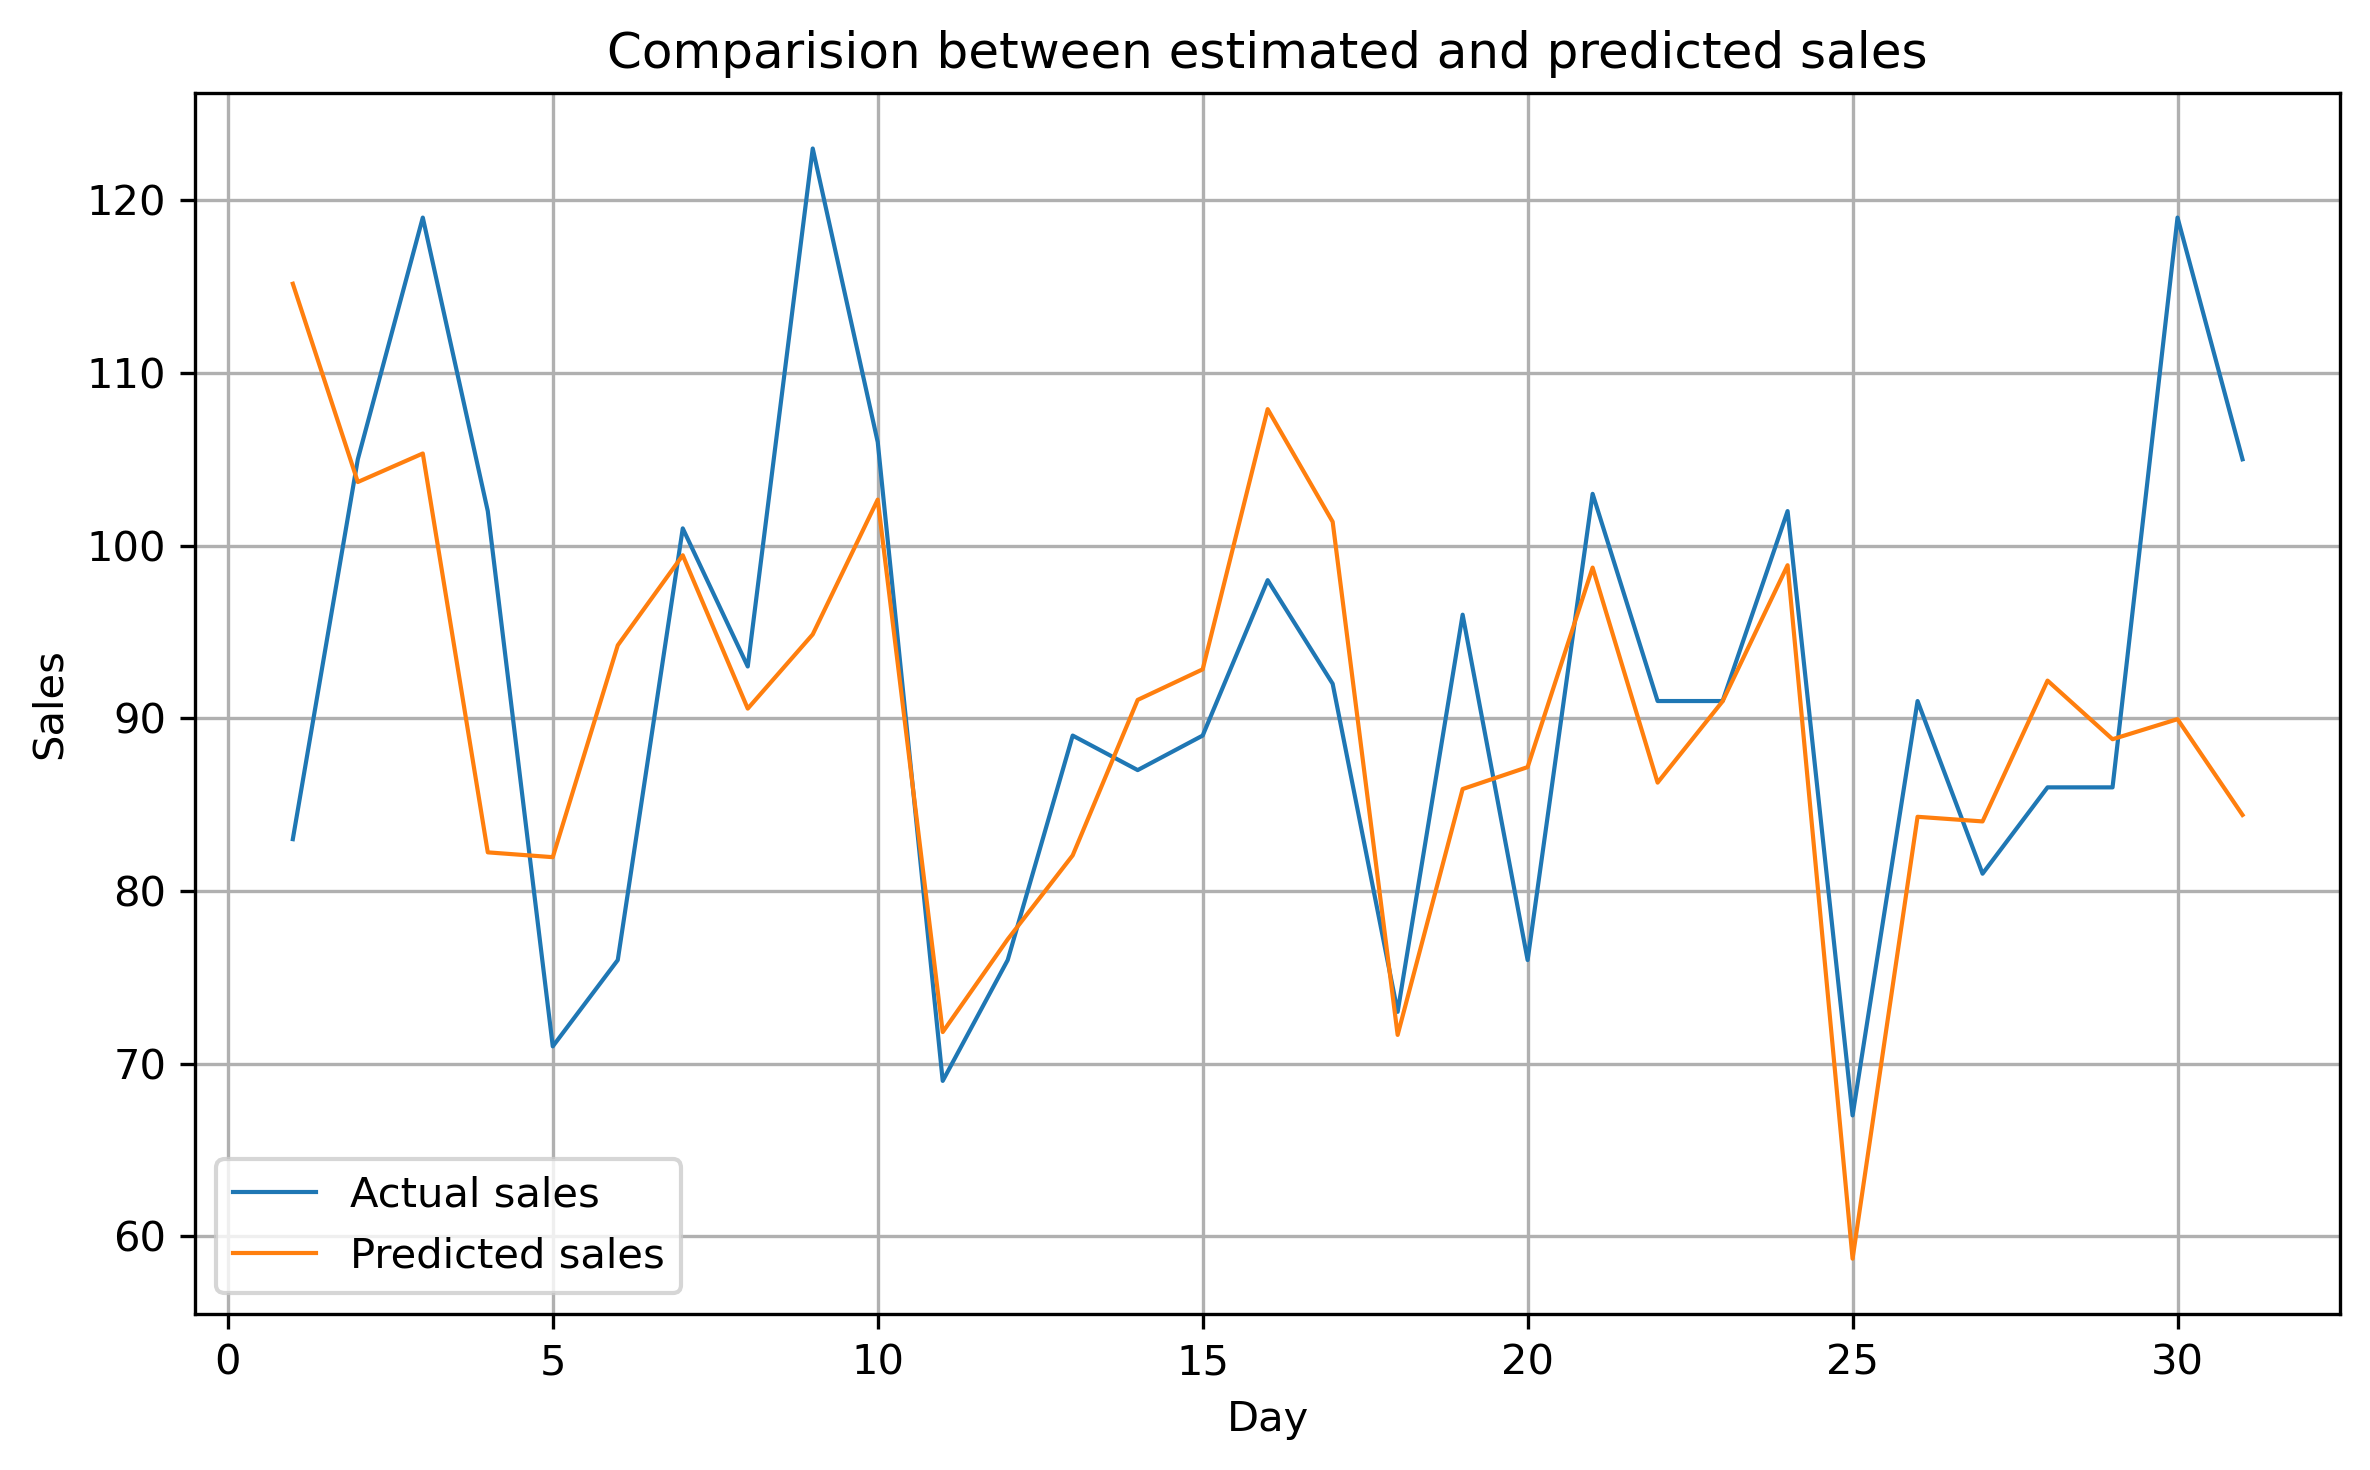

In [224]:
# December 2017 plot
plot_sales(x1=df_17[df_17['month']==12]['actual_sales'], x2=df_17[df_17['month']==12]['pred_sales'])

In [229]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df_17['actual_sales'],df_17['pred_sales'])

193.45012389893742